In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from io import StringIO
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn import tree

import os
os.environ["PATH"] += os.pathsep + 'D:/graphviz/Graphviz/bin'

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import graphviz

from IPython.display import display, HTML
from collections import *
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('output/clients_manages_tabular_time_series_v3.csv')
data.head()

,id_client,date,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,solde_std,nb_couple_av_enf_std,...,geo_localite,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,cnc_dtdval
0,0,20180131,528.85,0.0,528.85,0.0,0.0,530.0,-81.18,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
1,0,20180228,528.85,0.0,528.85,0.0,0.0,530.0,-82.33,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
2,0,20180331,528.85,0.0,528.85,0.0,0.0,530.0,-83.48,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
3,0,20180430,528.85,0.0,528.85,0.0,0.0,530.0,-84.63,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31
4,0,20180531,528.85,0.0,528.85,0.0,0.0,530.0,-85.78,1.0,...,-1,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.0,2018-01-31


In [3]:
list(data.columns)

['id_client',
 'date',
 'mnt_ttc_echeance_std',
 'mnt_solde_charges_ccl_std',
 'mnt_ttc_facture_ccl_std',
 'mnt_sls_ccl_std',
 'mnt_aides_ccl_std',
 'mnt_total_encaisse_std',
 'solde_std',
 'nb_couple_av_enf_std',
 'nb_divorce_std',
 'nb_monoparental_std',
 'nb_veuf_std',
 'nb_celibataire_std',
 'nbr_enfant_std',
 'nb_couple_ss_enf_std',
 'nbr_occupant_menage_std',
 'mnt_ressource_mensuel_std',
 'nb_pacse_std',
 'mnt_plafond_plus_std',
 'nb_menage_autre_std',
 'nb_seul_std',
 'nb_concubin_std',
 'nb_marie_std',
 'mnt_revenu_imp_n_std',
 'nb_separe_std',
 'type_revenu_lib',
 'mnt_loyer_ccl_std',
 'cnc_dteff',
 'geo_cp',
 'geo_region_lib',
 'elo_etage',
 'type_cnc_lib',
 'type_elo_lib',
 'elo_dtf_construction',
 'elo_mode_chauffage',
 'geo_localite',
 'terme_lib',
 'age_std_x',
 'type_trf_lib',
 'elo_categ_financement_inii',
 'cnc_tem_apl',
 'cnc_tem_al',
 'cnc_tem_sls',
 'mnt_caution_dg_ccl_std',
 'cnc_dtdval']

## Test le hypothèse deux mois consécutives

In [4]:
# """  Determiner des dettes chaque personnes chaque mois
#      Si Solde_std > 0 alors Dette = Solde_std 
#      Sinon 0
# """ 
# data["dette"] = data["solde_std"].apply(lambda x : x if x > 0 else 0)
# data

In [5]:
# pourcentage = {}
# for i in date :
#     pourcentage[i] = len(data_test[data_test["dette_"+i]>0])/len(data_test)
# pourcentage

In [6]:
""" Determiner si une personne est endette
    Si dette[k] >= mnt_ttc_echeance_std[k]/2 deux mois consécutives alors 1
    Sinon -1
"""
pourcentage = []
pred = None
for date_count in pd.unique(data.date):
    tdate = data[data.date == date_count].sort_values(by=['id_client']).reset_index()
    if pred == None :
        pourcentage.append(len(tdate[tdate.solde_std > (tdate.mnt_ttc_echeance_std/2)])/len(tdate))
    else :
        tpred = data[data.date == pred].sort_values(by=['id_client']).reset_index()
#         tpred = tpred.rename(columns = {"solde_std": "solde_std_pred", "mnt_ttc_echeance_std": "mnt_ttc_echeance_std_pred"})[["solde_std_pred", "mnt_ttc_echeance_std_pred"]]
#         tdate = tdate[["solde_std", "mnt_ttc_echeance_std"]]
#         new_data = pd.concat([tdate, tpred], axis = 1)
#         new_data["endette"] = (new_data['solde_std'] > new_data['mnt_ttc_echeance_std']/2) & \
#                               (new_data['solde_std_pred'] > new_data['mnt_ttc_echeance_std_pred']/2)
#         pourcentage.append(len(new_data[new_data["endette"] == True])/len(tdate))
        
        idx = np.where(np.logical_and((tdate.solde_std > tdate.mnt_ttc_echeance_std/2), (tpred.solde_std > tpred.mnt_ttc_echeance_std/2)))[0]

        pourcentage.append(len(idx)/len(tdate))
    pred = date_count

In [7]:
pred = None
new_data = None
for date_count in pd.unique(data.date) :
    tdate = data[data.date == date_count].sort_values(by=['id_client']).reset_index()
    if pred == None :
        new_data = tdate
        new_data["endette"] = new_data["solde_std"] > new_data["mnt_ttc_echeance_std"]/2
        new_data = new_data[["id_client", "date", "endette"]]
    else :
#         pass
        tpred = data[data.date == pred].sort_values(by=['id_client']).reset_index()
        tpred = tpred.rename(columns = {"solde_std": "solde_std_pred", "mnt_ttc_echeance_std": "mnt_ttc_echeance_std_pred"})[["solde_std_pred", "mnt_ttc_echeance_std_pred"]]
        buf_data = pd.concat([tdate, tpred], axis = 1)
        buf_data["endette"] = (buf_data['solde_std'] > buf_data['mnt_ttc_echeance_std']/2) & \
                              (buf_data['solde_std_pred'] > buf_data['mnt_ttc_echeance_std_pred']/2)
        buf_data = buf_data[["id_client", "date", "endette"]]
        new_data = pd.concat([new_data, buf_data], axis = 0)
    pred = date_count

In [8]:
new_data = new_data.sort_values(by=["id_client", "date"])
data = data.merge(new_data, on=["id_client", "date"])
data

,id_client,date,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,solde_std,nb_couple_av_enf_std,...,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,cnc_dtdval,endette
0,0,20180131,528.85,0.0,528.85,0.0,0.0,530.00,-81.18,1.0,...,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.00,2018-01-31,False
1,0,20180228,528.85,0.0,528.85,0.0,0.0,530.00,-82.33,1.0,...,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.00,2018-01-31,False
2,0,20180331,528.85,0.0,528.85,0.0,0.0,530.00,-83.48,1.0,...,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.00,2018-01-31,False
3,0,20180430,528.85,0.0,528.85,0.0,0.0,530.00,-84.63,1.0,...,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.00,2018-01-31,False
4,0,20180531,528.85,0.0,528.85,0.0,0.0,530.00,-85.78,1.0,...,TERME ECHU,50.0,Relocation,PLC,0.0,0.0,0.0,0.00,2018-01-31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334690,19749,20190531,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,...,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,485.53,2018-01-31,False
334691,19749,20190630,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,...,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,485.53,2018-01-31,False
334692,19749,20190731,0.00,0.0,0.00,0.0,0.0,0.00,0.00,0.0,...,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,485.53,2018-01-31,False
334693,19749,20190831,0.00,0.0,0.00,0.0,0.0,485.53,0.00,0.0,...,TERME ECHU,50.0,Relocation,PL2,0.0,0.0,0.0,485.53,2018-01-31,False


In [9]:
data.isnull().sum()

id_client                     0
date                          0
mnt_ttc_echeance_std          0
mnt_solde_charges_ccl_std     0
mnt_ttc_facture_ccl_std       0
mnt_sls_ccl_std               0
mnt_aides_ccl_std             0
mnt_total_encaisse_std        0
solde_std                     0
nb_couple_av_enf_std          0
nb_divorce_std                0
nb_monoparental_std           0
nb_veuf_std                   0
nb_celibataire_std            0
nbr_enfant_std                0
nb_couple_ss_enf_std          0
nbr_occupant_menage_std       0
mnt_ressource_mensuel_std     0
nb_pacse_std                  0
mnt_plafond_plus_std          0
nb_menage_autre_std           0
nb_seul_std                   0
nb_concubin_std               0
nb_marie_std                  0
mnt_revenu_imp_n_std          0
nb_separe_std                 0
type_revenu_lib               0
mnt_loyer_ccl_std             0
cnc_dteff                     0
geo_cp                        0
geo_region_lib                0
elo_etag

In [10]:
date = pd.unique(data.date).tolist()
mean_endette = np.mean(pourcentage) * 100
pourcentage_df = pd.DataFrame({"date": date, "pourcentage": [x * 100 for x in pourcentage]}).set_index("date")
pourcentage_df

,pourcentage
date,
20180131,8.949416
20180228,7.003891
20180331,6.947408
20180430,7.644032
20180531,7.041546
20180630,6.664993
20180731,6.326095
20180831,6.370026
20180930,6.401406


In [11]:
def visualisation(data, titre) :
    fig, ax = plt.subplots()
    sns.boxplot(data=data)
    plt.title(titre)
#     ax.set_xticks(range(len(cols)))
#     ax.set_xticklabels(cols)
#     plt.xticks(rotation = 90)
    plt.savefig("boxplot_dette_du_mois.png")
    plt.show()

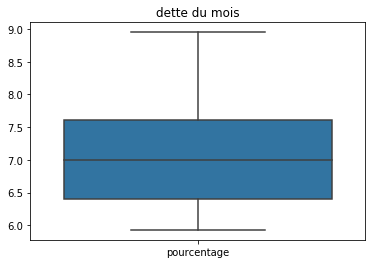

In [12]:
visualisation(pourcentage_df, 'dette du mois')

In [13]:
def surendetteplot(data, typeplot, title) :
    if (typeplot == "line") :
        index = data.index.values.tolist()
        cols = [str(x) for x in index]
        fig, ax = plt.subplots()
        sns.lineplot(x=cols, y = data['pourcentage'])
        sns.lineplot(x=cols, y = [mean_endette] * len(data.index.values), color='red')
        ax.set_xticks(range(len(cols)))
        ax.set_xticklabels(cols)
        plt.xticks(rotation = 90)
        plt.title("lineplot " + title)
        plt.ylabel("pourcentage des personnes en dette")
        plt.xlabel("date")
        plt.savefig('lineplot_pourcentage_des_personnes_en_dette.png')
        plt.show()
    if (typeplot == "bar") :
        index = data.index.values.tolist()
        cols = [str(x) for x in index]
        fig, ax = plt.subplots()
        sns.barplot(x=cols, y = data['pourcentage'])
        sns.lineplot(x=cols, y = [mean_endette] * len(data.index.values), color='red')
        ax.set_xticks(range(len(cols)))
        ax.set_xticklabels(cols)
        plt.xticks(rotation = 90)
        plt.title("barplot " + title)
        plt.ylabel("pourcentage des personnes en dette")
        plt.xlabel("date")
        plt.savefig('barplot_pourcentage_des_personnes_en_dette.png')
        plt.show()


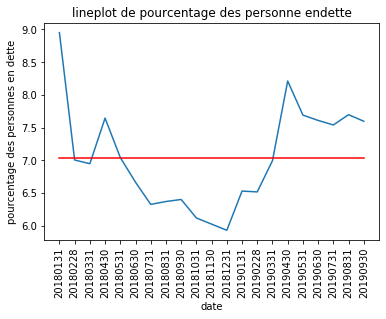

In [14]:
surendetteplot(pourcentage_df, "line", "de pourcentage des personne endette")

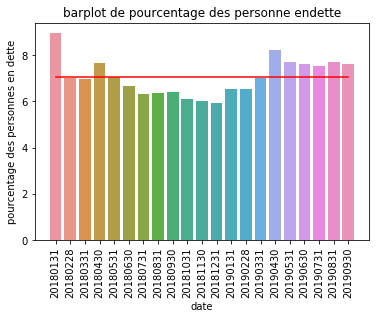

In [15]:
surendetteplot(pourcentage_df, "bar", "de pourcentage des personne endette")

## Analyse 

In [16]:
jan_2018_df = data[data.date == 20180131].sort_values(by=["id_client"]).reset_index(drop=True)
jan_2018_df

,id_client,date,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,solde_std,nb_couple_av_enf_std,...,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,cnc_dtdval,endette
0,0,20180131,528.85,0.0,528.85,0.0,0.0,530.00,-81.18,1.0,...,TERME ECHU,50.0,Relocation,PLC,0.000000,0.0,0.0,0.00,2018-01-31,False
1,1,20180131,528.85,0.0,111.85,0.0,-417.0,0.00,-653.09,1.0,...,TERME ECHU,35.0,Relocation,PLC,0.095238,0.0,0.0,0.00,2018-01-31,False
2,2,20180131,709.41,0.0,-104.59,0.0,-814.0,352.41,488.89,1.0,...,TERME ECHU,31.0,Relocation,PLC,0.000000,0.0,0.0,0.00,2018-01-31,True
3,3,20180131,542.83,0.0,542.83,0.0,0.0,542.83,52.54,0.0,...,TERME ECHU,48.0,Relocation,-1,0.000000,0.0,0.0,0.00,2018-01-31,False
4,6,20180131,309.32,0.0,309.32,0.0,0.0,389.32,614.12,0.0,...,TERME ECHU,75.0,Relocation,PLA,0.000000,0.0,0.0,0.00,2018-01-31,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15929,18357,20180131,620.14,0.0,620.14,0.0,0.0,274.00,100.07,0.0,...,TERME ECHU,35.0,Relocation,PL2,0.095238,0.0,0.0,0.00,2018-01-31,False
15930,18358,20180131,339.00,0.0,339.00,0.0,0.0,0.00,153.00,0.0,...,TERME ECHU,56.0,Relocation,-1,0.095238,0.0,0.0,7.55,2018-01-31,False
15931,18359,20180131,483.35,0.0,483.35,0.0,0.0,483.35,0.00,1.0,...,TERME ECHU,43.0,Relocation,PLU,0.000000,0.0,0.0,0.00,2018-01-31,False
15932,18360,20180131,594.27,0.0,594.27,0.0,0.0,594.27,0.00,1.0,...,TERME ECHU,39.0,Relocation,-1,0.000000,0.0,0.0,0.00,2018-01-31,False


In [17]:
cols_drop = [x for x in jan_2018_df.columns if (jan_2018_df[x].dtype != np.integer and jan_2018_df[x].dtype != np.float)]
cols_drop

['id_client',
 'date',
 'type_revenu_lib',
 'cnc_dteff',
 'geo_cp',
 'geo_region_lib',
 'elo_etage',
 'type_cnc_lib',
 'type_elo_lib',
 'elo_dtf_construction',
 'elo_mode_chauffage',
 'geo_localite',
 'terme_lib',
 'type_trf_lib',
 'elo_categ_financement_inii',
 'cnc_dtdval',
 'endette']

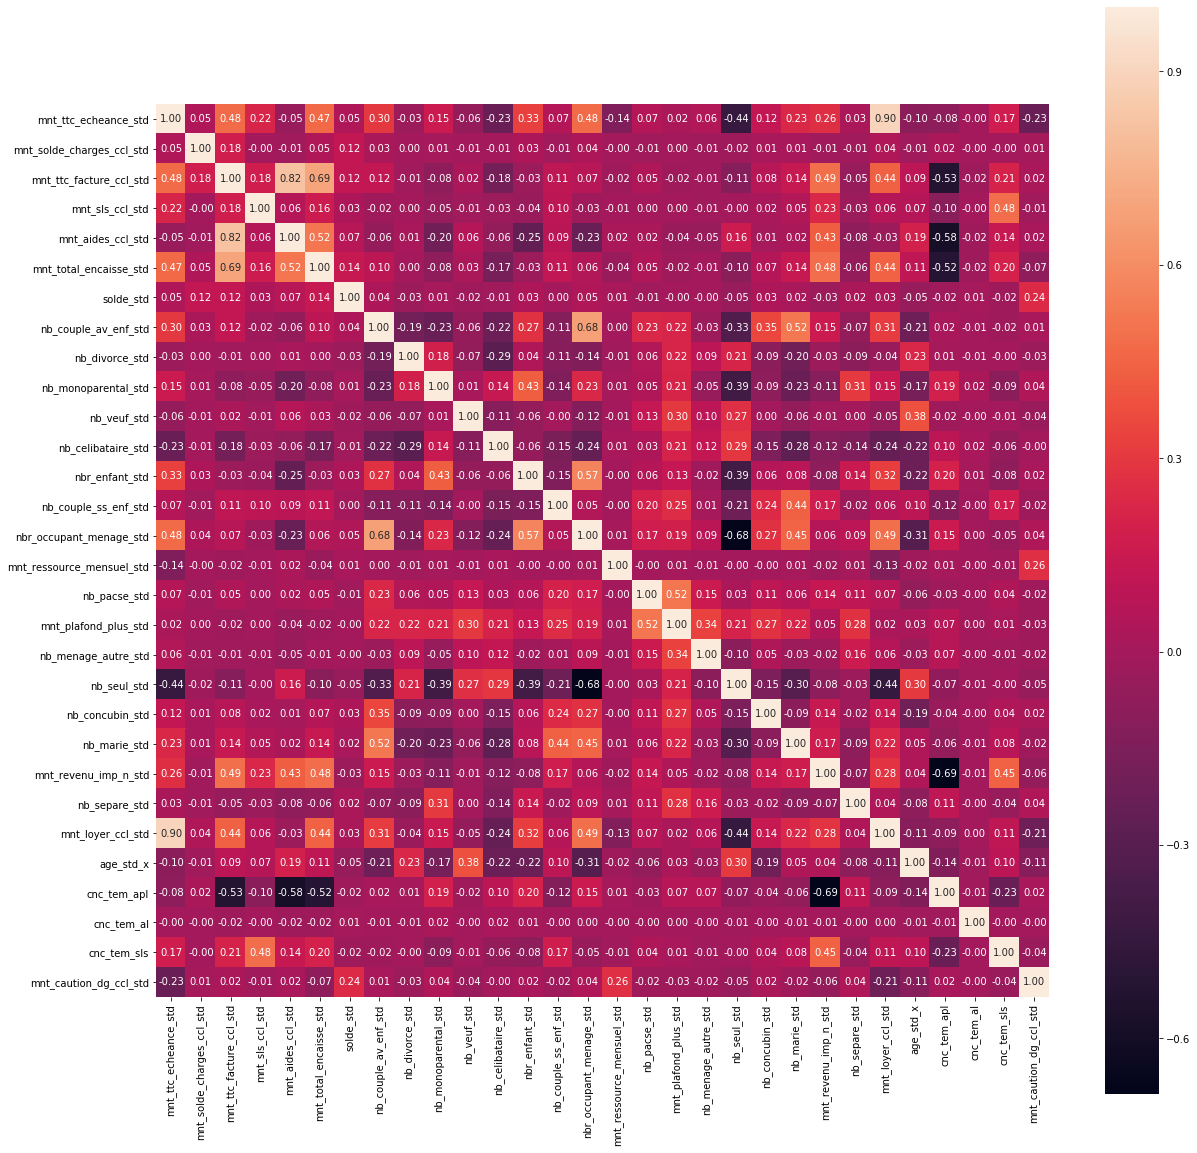

In [18]:
jan_2018_df[jan_2018_df.columns.drop(cols_drop)].corr()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(jan_2018_df[jan_2018_df.columns.drop(cols_drop)].corr(), square = True, annot = True, fmt = ".2f")
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig('correlation.png')
plt.show()


On a remarqué que **mnt_loyer_ccl_std** et **mnt_ttc_echeance_std** sont *très corrélées* (0.90). Donc on va supprimer un de deux colonnes là 

In [19]:
jan_2018_df = jan_2018_df.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
jan_2018_df.head()

,id_client,date,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,...,terme_lib,age_std_x,type_trf_lib,elo_categ_financement_inii,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,cnc_dtdval,endette
0,0,20180131,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,...,TERME ECHU,50.0,Relocation,PLC,0.000000,0.0,0.0,0.0,2018-01-31,False
1,1,20180131,528.85,0.0,111.85,0.0,-417.0,0.00,1.0,0.0,...,TERME ECHU,35.0,Relocation,PLC,0.095238,0.0,0.0,0.0,2018-01-31,False
2,2,20180131,709.41,0.0,-104.59,0.0,-814.0,352.41,1.0,0.0,...,TERME ECHU,31.0,Relocation,PLC,0.000000,0.0,0.0,0.0,2018-01-31,True
3,3,20180131,542.83,0.0,542.83,0.0,0.0,542.83,0.0,0.0,...,TERME ECHU,48.0,Relocation,-1,0.000000,0.0,0.0,0.0,2018-01-31,False
4,6,20180131,309.32,0.0,309.32,0.0,0.0,389.32,0.0,1.0,...,TERME ECHU,75.0,Relocation,PLA,0.000000,0.0,0.0,0.0,2018-01-31,True


## Feature selection

In [20]:
x = pd.get_dummies(jan_2018_df[cols_drop].drop(["id_client", "endette", "date"], axis = 1).astype("str"))
x

,type_revenu_lib_-1,type_revenu_lib_All. Adulte Handicapés,type_revenu_lib_All. Chomage_Indemnités,type_revenu_lib_All. éducation enfant ha,type_revenu_lib_Allo. Minimum Vieillesse,type_revenu_lib_Allocation Jeune Enfant,type_revenu_lib_Allocation familiales,type_revenu_lib_Autre (hors APL ou AL),type_revenu_lib_Pens. alimentaire reçue,type_revenu_lib_Pens. alimentaire versée,...,elo_categ_financement_inii_PLA,elo_categ_financement_inii_PLB,elo_categ_financement_inii_PLC,elo_categ_financement_inii_PLI,elo_categ_financement_inii_PLM,elo_categ_financement_inii_PLQ,elo_categ_financement_inii_PLU,elo_categ_financement_inii_PSR,elo_categ_financement_inii_PTS,cnc_dtdval_2018-01-31
0,0,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15929,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15930,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
15931,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
15932,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [21]:
jan_2018_df.drop(cols_drop[:len(cols_drop)-1], axis = 1).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15934 entries, 0 to 15933
Data columns (total 29 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   mnt_ttc_echeance_std       15934 non-null  float64
 1   mnt_solde_charges_ccl_std  15934 non-null  float64
 2   mnt_ttc_facture_ccl_std    15934 non-null  float64
 3   mnt_sls_ccl_std            15934 non-null  float64
 4   mnt_aides_ccl_std          15934 non-null  float64
 5   mnt_total_encaisse_std     15934 non-null  float64
 6   nb_couple_av_enf_std       15934 non-null  float64
 7   nb_divorce_std             15934 non-null  float64
 8   nb_monoparental_std        15934 non-null  float64
 9   nb_veuf_std                15934 non-null  float64
 10  nb_celibataire_std         15934 non-null  float64
 11  nbr_enfant_std             15934 non-null  float64
 12  nb_couple_ss_enf_std       15934 non-null  float64
 13  nbr_occupant_menage_std    15934 non-null  flo

### Test selection avec les variables numériques et les variable non numérique 

In [22]:
test_df = pd.concat([jan_2018_df.drop(cols_drop[:len(cols_drop)-1], axis = 1), x], axis = 1)
test_df

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,elo_categ_financement_inii_PLA,elo_categ_financement_inii_PLB,elo_categ_financement_inii_PLC,elo_categ_financement_inii_PLI,elo_categ_financement_inii_PLM,elo_categ_financement_inii_PLQ,elo_categ_financement_inii_PLU,elo_categ_financement_inii_PSR,elo_categ_financement_inii_PTS,cnc_dtdval_2018-01-31
0,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
1,528.85,0.0,111.85,0.0,-417.0,0.00,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
2,709.41,0.0,-104.59,0.0,-814.0,352.41,1.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,1
3,542.83,0.0,542.83,0.0,0.0,542.83,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
4,309.32,0.0,309.32,0.0,0.0,389.32,0.0,1.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15929,620.14,0.0,620.14,0.0,0.0,274.00,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,1
15930,339.00,0.0,339.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1
15931,483.35,0.0,483.35,0.0,0.0,483.35,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1,0,0,1
15932,594.27,0.0,594.27,0.0,0.0,594.27,1.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,1


In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    test_df.drop(['endette'], axis=1),
    test_df['endette'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((11153, 5713), (4781, 5713))

In [24]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [25]:
sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [26]:
unique, counts = np.unique(sel_.get_support(), return_counts=True)
d = test_df.drop("endette", axis=1).columns[sel_.get_support()]

len([x for x in d if ("geo_localite" in x)]) == len(jan_2018_df["geo_localite"].unique())
d = d.drop([x for x in d if ("geo_localite" in x)])
d = d.drop([x for x in d if ("cnc_dteff" in x)])
d = d.drop([x for x in d if ("geo_cp" in x)])
d = d.drop([x for x in d if ("geo_region_lib" in x)])
d = d.drop([x for x in d if ("elo_dtf_construction" in x)])
d = d.drop([x for x in d if ("elo_etage" in x)])
d = d.drop([x for x in d if ("type_elo_lib" in x)])
d = d.drop([x for x in d if ("type_revenu_lib" in x)])
d.tolist()

['mnt_ttc_echeance_std',
 'mnt_solde_charges_ccl_std',
 'mnt_ttc_facture_ccl_std',
 'mnt_sls_ccl_std',
 'mnt_aides_ccl_std',
 'mnt_total_encaisse_std',
 'nb_divorce_std',
 'nb_veuf_std',
 'nb_celibataire_std',
 'nbr_enfant_std',
 'nb_couple_ss_enf_std',
 'nbr_occupant_menage_std',
 'mnt_ressource_mensuel_std',
 'nb_pacse_std',
 'nb_menage_autre_std',
 'nb_marie_std',
 'nb_separe_std',
 'age_std_x',
 'cnc_tem_apl',
 'cnc_tem_al',
 'cnc_tem_sls',
 'mnt_caution_dg_ccl_std',
 'type_cnc_lib_Maison individuelle',
 'type_cnc_lib_Sans droit ni titre',
 'elo_mode_chauffage_Chauffage collectif Bois',
 'elo_mode_chauffage_Chauffage collectif gaz',
 'elo_mode_chauffage_Collectif gaz',
 'elo_mode_chauffage_Individuel Gaz de Ville',
 'elo_mode_chauffage_Individuel gaz',
 'elo_mode_chauffage_Individuel électrique',
 'elo_mode_chauffage_chauffage individuel gaz',
 'elo_mode_chauffage_chauffage individuel propane',
 'elo_mode_chauffage_chauffage individuel électrique',
 'type_trf_lib_Relocation',
 'typ

### Test seulement avec les variables numériques

In [27]:
test_df = jan_2018_df.drop(cols_drop[:len(cols_drop)-1], axis = 1)
test_df

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_concubin_std,nb_marie_std,mnt_revenu_imp_n_std,nb_separe_std,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,endette
0,528.85,0.0,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,0.0,1.0,30269.0,0.0,50.0,0.000000,0.0,0.0,0.00,False
1,528.85,0.0,111.85,0.0,-417.0,0.00,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,35.0,0.095238,0.0,0.0,0.00,False
2,709.41,0.0,-104.59,0.0,-814.0,352.41,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,31.0,0.000000,0.0,0.0,0.00,True
3,542.83,0.0,542.83,0.0,0.0,542.83,0.0,0.0,1.0,0.0,...,0.0,0.0,10720.0,0.0,48.0,0.000000,0.0,0.0,0.00,False
4,309.32,0.0,309.32,0.0,0.0,389.32,0.0,1.0,0.0,0.0,...,0.0,0.0,11812.0,0.0,75.0,0.000000,0.0,0.0,0.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15929,620.14,0.0,620.14,0.0,0.0,274.00,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,35.0,0.095238,0.0,0.0,0.00,False
15930,339.00,0.0,339.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,56.0,0.095238,0.0,0.0,7.55,False
15931,483.35,0.0,483.35,0.0,0.0,483.35,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,43.0,0.000000,0.0,0.0,0.00,False
15932,594.27,0.0,594.27,0.0,0.0,594.27,1.0,0.0,0.0,0.0,...,0.0,0.0,21407.0,0.0,39.0,0.000000,0.0,0.0,0.00,False


In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    test_df.drop(['endette'], axis=1),
    test_df['endette'],
    test_size=0.3,
    random_state=0)
X_train.shape, X_test.shape

((11153, 28), (4781, 28))

In [29]:
scaler = StandardScaler()
scaler.fit(X_train.fillna(0))

StandardScaler()

In [30]:
"""
    Utiliser la Lasso classifier pour selectionner les variables avec penalty l1

"""

sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
sel_.fit(scaler.transform(X_train.fillna(0)), y_train)

SelectFromModel(estimator=LogisticRegression(C=1, penalty='l1',
                                             solver='liblinear'))

In [31]:
model = LogisticRegression(C=1, penalty='l1', solver='liblinear')
model.fit(X_train.fillna(0), y_train)
model.predict(X_test)

sum(y_test == model.predict(X_test)) / len(y_test)

0.9171721397197239

In [32]:
unique, counts = np.unique(sel_.get_support(), return_counts=True)
d = test_df.drop("endette", axis=1).columns[sel_.get_support()]
d.tolist()

['mnt_ttc_echeance_std',
 'mnt_solde_charges_ccl_std',
 'mnt_ttc_facture_ccl_std',
 'mnt_sls_ccl_std',
 'mnt_aides_ccl_std',
 'mnt_total_encaisse_std',
 'nb_couple_av_enf_std',
 'nb_divorce_std',
 'nb_monoparental_std',
 'nb_veuf_std',
 'nb_celibataire_std',
 'nbr_enfant_std',
 'nbr_occupant_menage_std',
 'mnt_ressource_mensuel_std',
 'nb_pacse_std',
 'mnt_plafond_plus_std',
 'nb_menage_autre_std',
 'nb_seul_std',
 'nb_concubin_std',
 'nb_marie_std',
 'mnt_revenu_imp_n_std',
 'nb_separe_std',
 'age_std_x',
 'cnc_tem_apl',
 'cnc_tem_al',
 'cnc_tem_sls',
 'mnt_caution_dg_ccl_std']

In [33]:
sel_.estimator_.coef_

array([[ 0.62233565,  0.56734107, -1.21964519,  0.02319513,  0.96935487,
         0.46507234, -0.00761142, -0.14221593,  0.03090803, -0.05922904,
        -0.01160774, -0.01176367,  0.        ,  0.11675326, -0.05490042,
        -0.04209766,  0.03070133, -0.02803425,  0.06575341,  0.0275538 ,
        -0.01363168, -0.32857199,  0.04105518, -0.24699298, -0.01586812,
         0.10315681, -0.19976711,  0.71115465]])

In [34]:
sel_.estimator_.coef_.ravel()

array([ 0.62233565,  0.56734107, -1.21964519,  0.02319513,  0.96935487,
        0.46507234, -0.00761142, -0.14221593,  0.03090803, -0.05922904,
       -0.01160774, -0.01176367,  0.        ,  0.11675326, -0.05490042,
       -0.04209766,  0.03070133, -0.02803425,  0.06575341,  0.0275538 ,
       -0.01363168, -0.32857199,  0.04105518, -0.24699298, -0.01586812,
        0.10315681, -0.19976711,  0.71115465])

In [35]:
sel_.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [36]:
len(d)

27

### Selection features pour chaque mois pour comparer

>- ici on applique pour seulement les mois qui sont considerées comme surendettées: jan-2018, avril-2018, de avril à septembre 2019

In [37]:
""" fonction select_feature pour selectionner des variables importantes
    @Param
        data
        data_select
        pred = True si client est déjà existé
             = False sinon
"""


def selection_feature(data, date_select, pred = False) :
    if (date_select == 20180131 or pred == False) :
        date_select_df = data[data.date == date_select].sort_values(by=["id_client"]).reset_index(drop=True)
        cols_drop = [x for x in date_select_df.columns if (date_select_df[x].dtype != np.integer and date_select_df[x].dtype != np.float)]
        date_select_df = date_select_df.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
        test_df = date_select_df.drop(cols_drop[:len(cols_drop)-1], axis = 1)
        X_train, X_test, y_train, y_test = train_test_split(test_df.drop(['endette'], axis=1),
                                                            test_df['endette'],
                                                            test_size=0.3,
                                                            random_state=0)
        scaler = StandardScaler()
        scaler.fit(X_train.fillna(0))
        
        sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
        sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
        unique, counts = np.unique(sel_.get_support(), return_counts=True)
        d = test_df.drop("endette", axis=1).columns[sel_.get_support()].tolist()
        
        
        return [sel_, test_df.columns.drop("endette").tolist(), d]
    else :
        for i in range(len(date)) :
            if date[i] == date_select :
                date_pred = date[i-1]
                break;
        tdate = data[data.date == date_select].sort_values(by=["id_client"]).reset_index(drop=True)
        tpred = data[data.date == date_pred].sort_values(by=["id_client"]).reset_index(drop=True)
        cols_drop = [x for x in tdate.columns if (tdate[x].dtype != np.integer and tdate[x].dtype != np.float)]
        tdate = tdate.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
        tpred = tpred.drop(["endette"], axis = 1)
        tpred = tpred.drop(cols_drop[:len(cols_drop)-1], axis = 1)
        tpred = tpred.rename(columns = {i : (i + "_pred") for i in tpred.columns})
        tdate = tdate.drop(cols_drop[:len(cols_drop)-1], axis = 1)
        buf_data = pd.concat([tdate, tpred], axis = 1)
        X_train, X_test, y_train, y_test = train_test_split(buf_data.drop(['endette'], axis=1),
                                                            buf_data['endette'],
                                                            test_size=0.3,
                                                            random_state=0)
        scaler = StandardScaler()
        scaler.fit(X_train.fillna(0))
        
        sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
        sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
        unique, counts = np.unique(sel_.get_support(), return_counts=True)
        d = buf_data.drop("endette", axis=1).columns[sel_.get_support()].tolist()
        return [sel_, buf_data.columns.drop("endette").tolist(), d]

In [38]:
date_select = 20180430
for i in range(len(date)) :
    if date[i] == date_select :
        date_pred = date[i-1]
        break;
tdate = data[data.date == date_select].sort_values(by=["id_client"]).reset_index(drop=True)
tpred = data[data.date == date_pred].sort_values(by=["id_client"]).reset_index(drop=True)
cols_drop = [x for x in tdate.columns if (tdate[x].dtype != np.integer and tdate[x].dtype != np.float)]
tdate = tdate.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
tpred = tpred.drop(["endette"], axis = 1)
tpred = tpred.drop(cols_drop[:len(cols_drop)-1], axis = 1)
tpred = tpred.rename(columns = {i : (i + "_pred") for i in tpred.columns})
tdate = tdate.drop(cols_drop[:len(cols_drop)-1], axis = 1)
buf_data = pd.concat([tdate, tpred], axis = 1)
buf_data

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_concubin_std_pred,nb_marie_std_pred,mnt_revenu_imp_n_std_pred,nb_separe_std_pred,mnt_loyer_ccl_std_pred,age_std_x_pred,cnc_tem_apl_pred,cnc_tem_al_pred,cnc_tem_sls_pred,mnt_caution_dg_ccl_std_pred
0,528.85,0.00,528.85,0.0,0.0,530.00,1.0,0.0,0.0,0.0,...,0.0,1.0,30269.0,0.0,508.85,50.0,0.000000,0.0,0.0,0.00
1,528.85,0.00,2.85,0.0,-526.0,0.00,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,508.85,35.0,0.095238,0.0,0.0,0.00
2,709.41,0.00,-104.59,0.0,-814.0,352.41,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,684.41,31.0,0.000000,0.0,0.0,0.00
3,542.83,0.00,542.83,0.0,0.0,1092.03,0.0,0.0,1.0,0.0,...,0.0,0.0,10720.0,0.0,522.83,48.0,0.000000,0.0,0.0,0.00
4,309.32,-148.34,160.98,0.0,0.0,-340.68,0.0,1.0,0.0,0.0,...,0.0,0.0,11812.0,0.0,253.79,75.0,0.000000,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15929,620.14,0.00,349.14,0.0,-271.0,349.14,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,521.57,35.0,0.095238,0.0,0.0,0.00
15930,339.00,0.00,70.00,0.0,-269.0,70.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,289.43,56.0,0.095238,0.0,0.0,7.55
15931,483.35,0.00,483.35,0.0,0.0,483.35,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,454.61,43.0,0.000000,0.0,0.0,0.00
15932,594.27,0.00,594.27,0.0,0.0,594.27,1.0,0.0,0.0,0.0,...,0.0,0.0,21407.0,0.0,566.29,39.0,0.000000,0.0,0.0,0.00


In [39]:
surendette_date = pourcentage_df[pourcentage_df["pourcentage"] > mean_endette].index.tolist()
surendette_date

[20180131,
 20180430,
 20180531,
 20190430,
 20190531,
 20190630,
 20190731,
 20190831,
 20190930]

In [40]:
"""
    features pour clients qui est connu 1 seule mois

"""


list_feature = set([])
coef = np.zeros(28)
feature_total = []
for i in surendette_date :
    print("feature of " + str(i) + " :")
    print(selection_feature(data, i)[2])
    list_feature = list_feature.union(set(selection_feature(data, i)[2]))
    feature_total = selection_feature(data, i)[1]
    coef += selection_feature(data, i)[0].estimator_.coef_.ravel()
    print("-" * 120)
coef = coef / len(surendette_date)

feature of 20180131 :
['mnt_ttc_echeance_std', 'mnt_solde_charges_ccl_std', 'mnt_ttc_facture_ccl_std', 'mnt_sls_ccl_std', 'mnt_aides_ccl_std', 'mnt_total_encaisse_std', 'nb_couple_av_enf_std', 'nb_divorce_std', 'nb_monoparental_std', 'nb_veuf_std', 'nb_celibataire_std', 'nbr_enfant_std', 'nbr_occupant_menage_std', 'mnt_ressource_mensuel_std', 'nb_pacse_std', 'mnt_plafond_plus_std', 'nb_menage_autre_std', 'nb_seul_std', 'nb_concubin_std', 'nb_marie_std', 'mnt_revenu_imp_n_std', 'nb_separe_std', 'age_std_x', 'cnc_tem_apl', 'cnc_tem_al', 'cnc_tem_sls', 'mnt_caution_dg_ccl_std']
------------------------------------------------------------------------------------------------------------------------
feature of 20180430 :
['mnt_ttc_echeance_std', 'mnt_solde_charges_ccl_std', 'mnt_ttc_facture_ccl_std', 'mnt_sls_ccl_std', 'mnt_aides_ccl_std', 'mnt_total_encaisse_std', 'nb_couple_av_enf_std', 'nb_divorce_std', 'nb_monoparental_std', 'nb_veuf_std', 'nb_celibataire_std', 'nbr_enfant_std', 'nb_coup

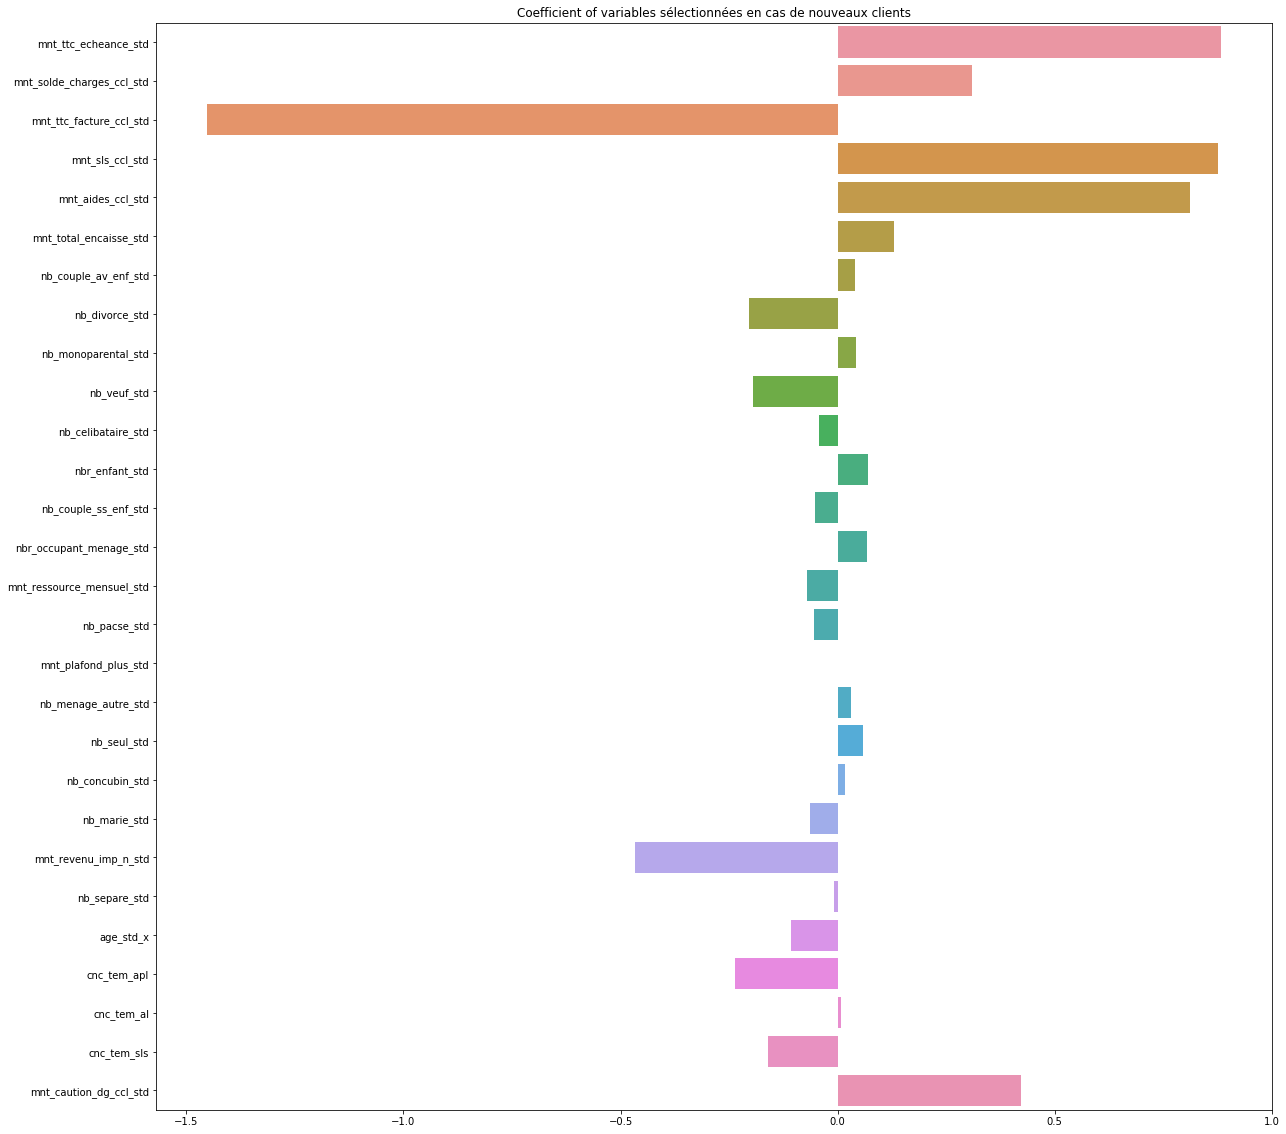

In [41]:
list_feature = list(list_feature)
coef
feature_total
fig = plt.figure(figsize=(20, 20))
sns.barplot(coef, feature_total)
plt.title("Coefficient of variables sélectionnées en cas de nouveaux clients")
# plt.xticks(rotation= 90)
plt.savefig('Coefficient_of_variables_sélectionnées_en_cas_de_nouveaux_clients.png')
plt.show()


In [42]:
list_feature_pred = set([])
coef = np.zeros(58)
feature_total = []
for i in surendette_date[1:] :
    print("feature of " + str(i) + " :")
    print(selection_feature(data, i, True)[2])
    list_feature_pred = list_feature_pred.union(set(selection_feature(data, i, True)[2]))
    feature_total = selection_feature(data, i, True)[1]
    coef += selection_feature(data, i, True)[0].estimator_.coef_.ravel()
    print("-" * 120)
coef = coef / (len(surendette_date) - 1)

feature of 20180430 :
['mnt_ttc_echeance_std', 'mnt_solde_charges_ccl_std', 'mnt_ttc_facture_ccl_std', 'mnt_aides_ccl_std', 'mnt_total_encaisse_std', 'nb_divorce_std', 'nb_monoparental_std', 'nb_veuf_std', 'nb_celibataire_std', 'nbr_enfant_std', 'nb_couple_ss_enf_std', 'nbr_occupant_menage_std', 'mnt_ressource_mensuel_std', 'nb_pacse_std', 'mnt_plafond_plus_std', 'nb_menage_autre_std', 'nb_seul_std', 'nb_marie_std', 'mnt_revenu_imp_n_std', 'nb_separe_std', 'age_std_x', 'cnc_tem_apl', 'cnc_tem_al', 'cnc_tem_sls', 'mnt_ttc_echeance_std_pred', 'mnt_solde_charges_ccl_std_pred', 'mnt_sls_ccl_std_pred', 'mnt_aides_ccl_std_pred', 'mnt_total_encaisse_std_pred', 'solde_std_pred', 'nb_divorce_std_pred', 'nb_monoparental_std_pred', 'nb_veuf_std_pred', 'nb_celibataire_std_pred', 'nbr_enfant_std_pred', 'nb_couple_ss_enf_std_pred', 'nbr_occupant_menage_std_pred', 'mnt_ressource_mensuel_std_pred', 'nb_pacse_std_pred', 'mnt_plafond_plus_std_pred', 'nb_menage_autre_std_pred', 'nb_seul_std_pred', 'nb_ma

------------------------------------------------------------------------------------------------------------------------
feature of 20190930 :
['mnt_ttc_echeance_std', 'mnt_solde_charges_ccl_std', 'mnt_ttc_facture_ccl_std', 'mnt_sls_ccl_std', 'mnt_aides_ccl_std', 'mnt_total_encaisse_std', 'nb_divorce_std', 'nb_monoparental_std', 'nb_veuf_std', 'nbr_enfant_std', 'nb_couple_ss_enf_std', 'nbr_occupant_menage_std', 'nb_pacse_std', 'mnt_plafond_plus_std', 'nb_menage_autre_std', 'nb_concubin_std', 'mnt_revenu_imp_n_std', 'age_std_x', 'cnc_tem_apl', 'cnc_tem_sls', 'mnt_caution_dg_ccl_std', 'mnt_ttc_echeance_std_pred', 'mnt_sls_ccl_std_pred', 'mnt_aides_ccl_std_pred', 'mnt_total_encaisse_std_pred', 'solde_std_pred', 'nb_couple_av_enf_std_pred', 'nb_divorce_std_pred', 'nb_monoparental_std_pred', 'nb_veuf_std_pred', 'nbr_enfant_std_pred', 'nb_couple_ss_enf_std_pred', 'nbr_occupant_menage_std_pred', 'nb_pacse_std_pred', 'mnt_plafond_plus_std_pred', 'nb_menage_autre_std_pred', 'nb_concubin_std_pre

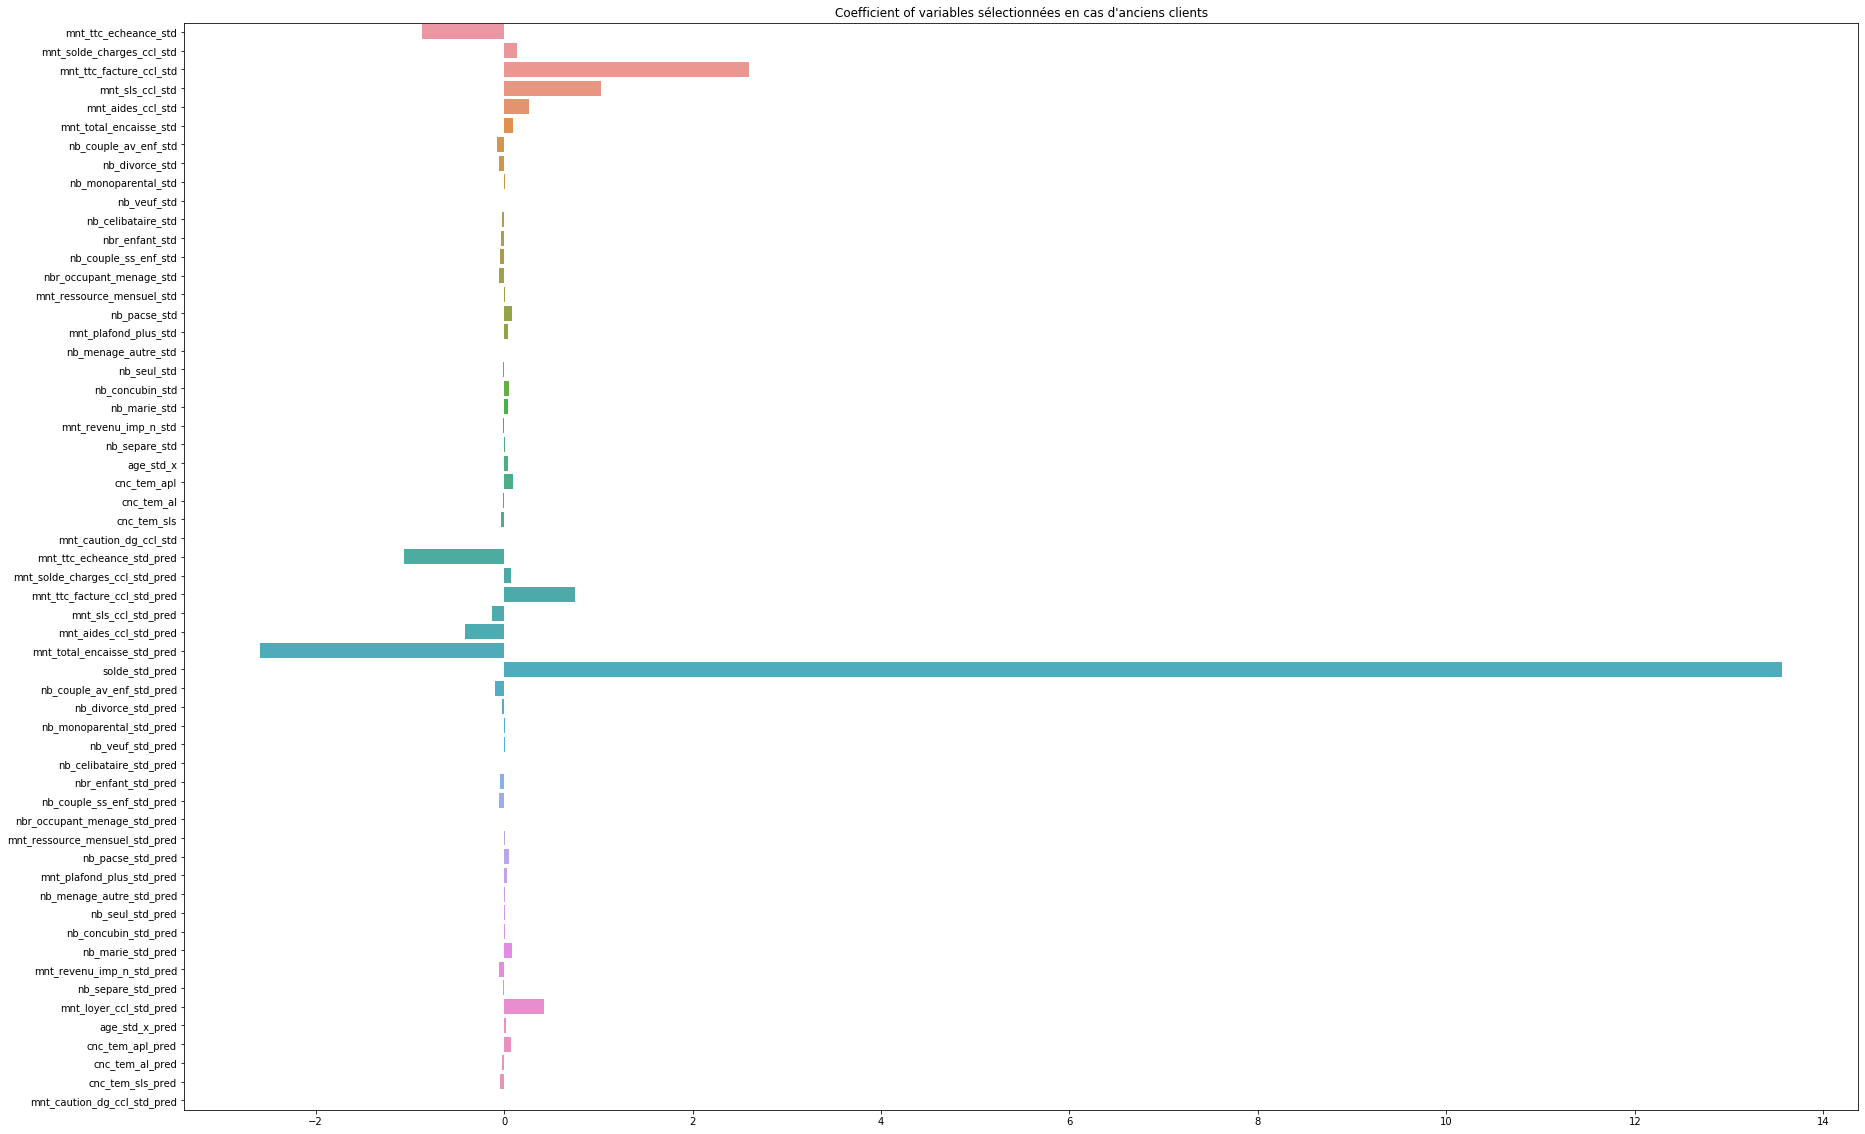

In [43]:
len(list_feature_pred)
fig = plt.figure(figsize=(30, 20))
sns.barplot(coef, feature_total)
# plt.xticks(rotation= 90)
plt.title("Coefficient of variables sélectionnées en cas d'anciens clients")
plt.savefig('Coefficient_of_variables_sélectionnées_en_cas_d\'anciens_clients.png')
plt.show()


In [44]:
"""
    Version 2 pour selectionner des variables en combinaisionner les périodes surendettées

"""


def selection_feature_v2(data, pred = False) :
    if (pred == False) :
        date_select_df = None
        for i in range(len(surendette_date)) :
            if (i == 0) :
                date_select_df = data[data.date == surendette_date[i]].sort_values(by=["id_client"]).reset_index(drop=True)
            else :
                date_select_df = pd.concat([date_select_df ,
                                            data[data.date == surendette_date[i]].sort_values(by=["id_client"]).reset_index(drop=True)], \
                                            axis = 0)
        cols_drop = [x for x in date_select_df.columns if (date_select_df[x].dtype != np.integer and date_select_df[x].dtype != np.float)]
        date_select_df = date_select_df.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
        test_df = date_select_df.drop(cols_drop[:len(cols_drop)-1], axis = 1)
        X_train, X_test, y_train, y_test = train_test_split(test_df.drop(['endette'], axis=1),
                                                            test_df['endette'],
                                                            test_size=0.3,
                                                            random_state=0)
        scaler = StandardScaler()
        scaler.fit(X_train.fillna(0))
        sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
        sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
        unique, counts = np.unique(sel_.get_support(), return_counts=True)
        d = test_df.drop("endette", axis=1).columns[sel_.get_support()].tolist()
        return [sel_, test_df.columns.drop("endette").tolist(), d]
    else :
        lst_date = []
        for i in range(len(surendette_date)) :
            if (i == 0) :
                pass
            else :
                for j in range(len(date)) :
                    if (surendette_date[i] == date[j]) :
                        date_pred = date[j-1]
                        date_select = surendette_date[i]
                        lst_date.append([date_select, date_pred])
        buf_data = []               
        for date_select, date_pred in lst_date :       
            tdate = data[data.date == date_select].sort_values(by=["id_client"]).reset_index(drop=True)
            tpred = data[data.date == date_pred].sort_values(by=["id_client"]).reset_index(drop=True)
            cols_drop = [x for x in tdate.columns if (tdate[x].dtype != np.integer and tdate[x].dtype != np.float)]
            tdate = tdate.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
            tpred = tpred.drop(["endette"], axis = 1)
            tpred = tpred.drop(cols_drop[:len(cols_drop)-1], axis = 1)
            tpred = tpred.rename(columns = {i : (i + "_pred") for i in tpred.columns})
            tdate = tdate.drop(cols_drop[:len(cols_drop)-1], axis = 1)
            if len(buf_data) == 0 :
                buf_data = pd.concat([tdate, tpred], axis = 1)
            else :
                buf_data = pd.concat([buf_data, pd.concat([tdate, tpred], axis = 1)], axis = 0)
        X_train, X_test, y_train, y_test = train_test_split(buf_data.drop(['endette'], axis=1),
                                                            buf_data['endette'],
                                                            test_size=0.3,
                                                            random_state=0)
        scaler = StandardScaler()
        scaler.fit(X_train.fillna(0))
        sel_ = SelectFromModel(LogisticRegression(C=1, penalty='l1', solver='liblinear'))
        sel_.fit(scaler.transform(X_train.fillna(0)), y_train)
        unique, counts = np.unique(sel_.get_support(), return_counts=True)
        d = buf_data.drop("endette", axis=1).columns[sel_.get_support()].tolist()
        return [sel_, buf_data.columns.drop("endette").tolist(), d]

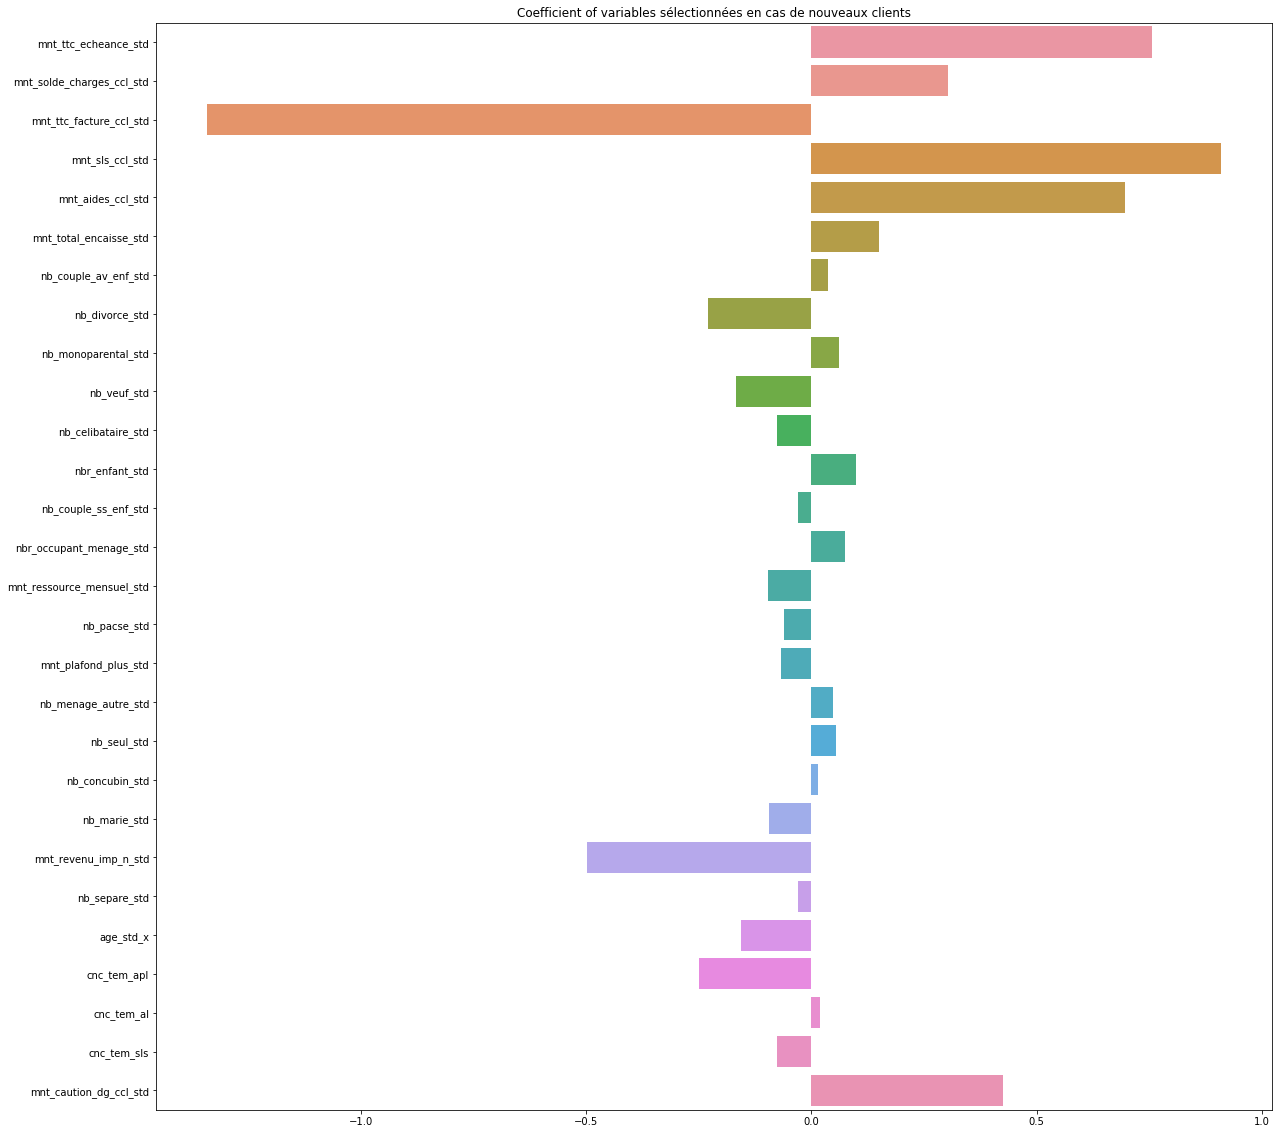

In [45]:
fig = plt.figure(figsize=(20, 20))
sns.barplot(selection_feature_v2(data, False)[0].estimator_.coef_.ravel(), selection_feature_v2(data, False)[1])
plt.title("Coefficient of variables sélectionnées en cas de nouveaux clients")
# plt.xticks(rotation= 90)
plt.savefig('Coefficient_of_variables_sélectionnées_en_cas_de_nouveaux_clients_v2.png')
plt.show()

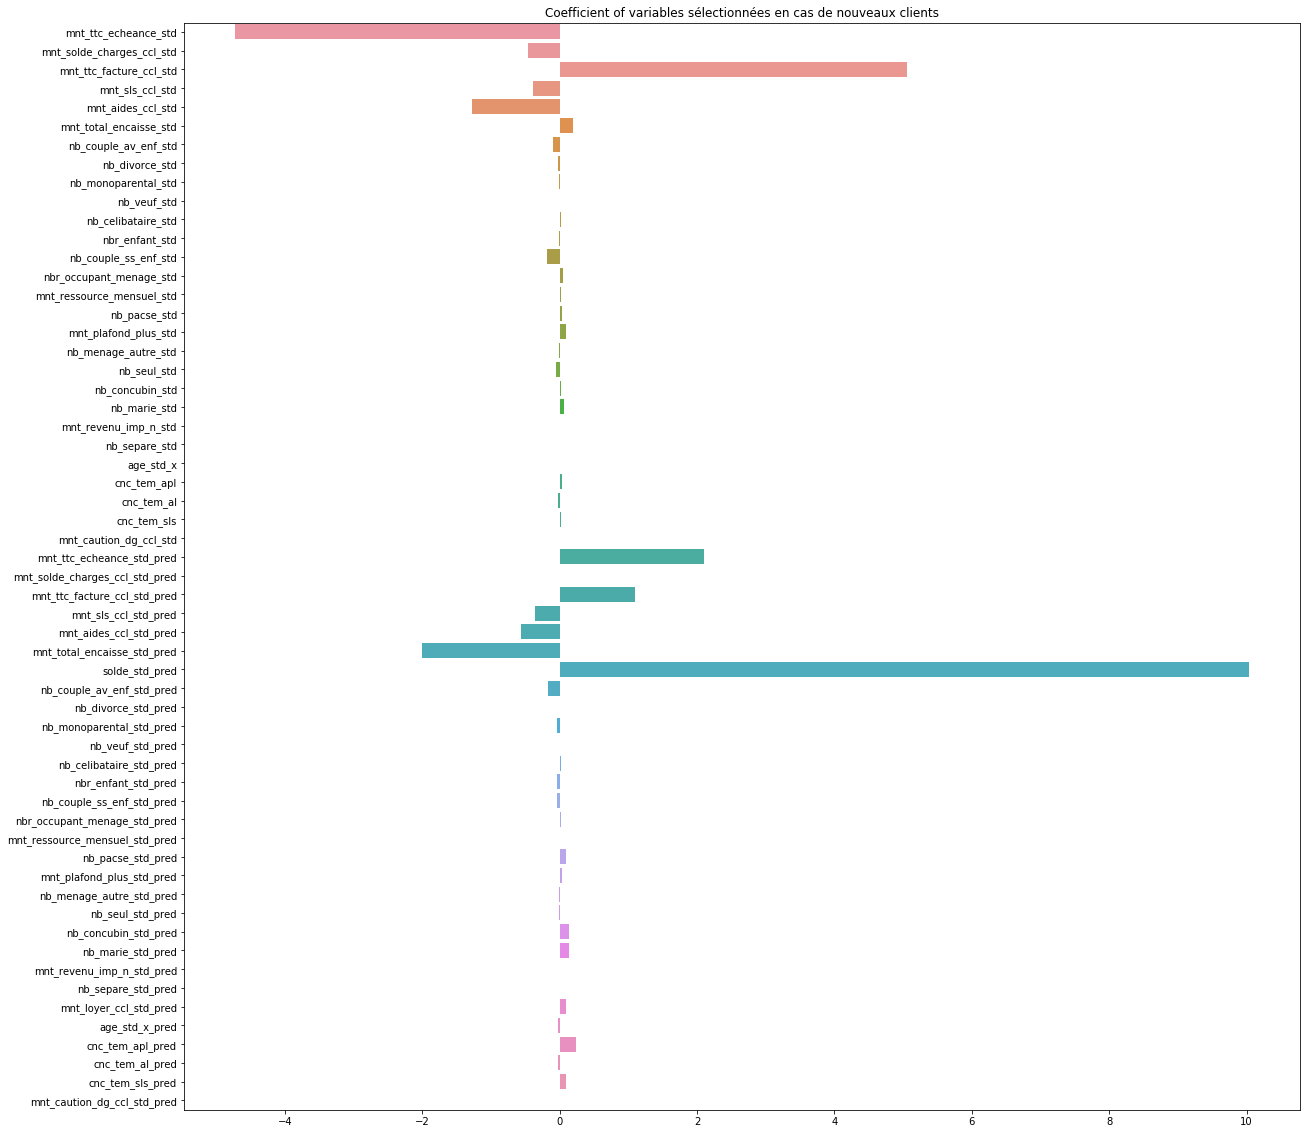

In [46]:
fig = plt.figure(figsize=(20, 20))
sns.barplot(selection_feature_v2(data, True)[0].estimator_.coef_.ravel(), selection_feature_v2(data, True)[1])
plt.title("Coefficient of variables sélectionnées en cas de nouveaux clients")
# plt.xticks(rotation= 90)
plt.savefig('Coefficient_of_variables_sélectionnées_en_cas_d\'anciens_clients_v2.png')
plt.show()

In [47]:
d2 = selection_feature_v2(data, True)[2]

In [48]:
d1 = selection_feature_v2(data, False)[2]

In [49]:
len(d2)

54

In [50]:
len(d1)

28

### Appliquer les algorithmes de classification et déterminer quel modèle est le meilleur

> Ici on va utiliser les méthodes dessous :
>- Lasso Classification
>- Algorithms de l'arbre:
    Decision Tree Classification :
        * Prune
        * Bagging
    RandomForest 
    GradientBoosting
>- SVM
>- QDA, LDA
>- kNN Classifier


# 1. Prétraiter données

In [51]:
date_select_df = None
for i in range(len(surendette_date)) :
    if (i == 0) :
        date_select_df = data[data.date == surendette_date[i]].sort_values(by=["id_client"]).reset_index(drop=True)
    else :
        date_select_df = pd.concat([date_select_df ,
                                    data[data.date == surendette_date[i]].sort_values(by=["id_client"]).reset_index(drop=True)], \
                                    axis = 0)
cols_drop = [x for x in date_select_df.columns if (date_select_df[x].dtype != np.integer and date_select_df[x].dtype != np.float)]
date_select_df = date_select_df.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
one_month_df = date_select_df.drop(cols_drop[:len(cols_drop)-1], axis = 1)
one_month_df

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_concubin_std,nb_marie_std,mnt_revenu_imp_n_std,nb_separe_std,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std,endette
0,528.85,0.0,528.85,0.0,0.00,530.00,1.0,0.0,0.0,0.0,...,0.0,1.0,30269.0,0.0,50.0,0.000000,0.0,0.0,0.00,False
1,528.85,0.0,111.85,0.0,-417.00,0.00,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,35.0,0.095238,0.0,0.0,0.00,False
2,709.41,0.0,-104.59,0.0,-814.00,352.41,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,31.0,0.000000,0.0,0.0,0.00,True
3,542.83,0.0,542.83,0.0,0.00,542.83,0.0,0.0,1.0,0.0,...,0.0,0.0,10720.0,0.0,48.0,0.000000,0.0,0.0,0.00,False
4,309.32,0.0,309.32,0.0,0.00,389.32,0.0,1.0,0.0,0.0,...,0.0,0.0,11812.0,0.0,75.0,0.000000,0.0,0.0,0.00,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15938,565.63,0.0,129.52,0.0,-391.66,129.52,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,30.0,0.111111,0.0,0.0,445.28,False
15939,498.36,0.0,498.36,0.0,0.00,498.36,0.0,0.0,1.0,0.0,...,0.0,0.0,17384.0,0.0,29.0,0.000000,0.0,0.0,450.62,False
15940,562.60,0.0,562.60,0.0,0.00,562.60,1.0,0.0,0.0,0.0,...,0.0,1.0,35915.0,0.0,38.0,0.000000,0.0,0.0,499.02,False
15941,525.10,0.0,525.10,0.0,0.00,525.10,0.0,0.0,1.0,0.0,...,0.0,0.0,6152.0,1.0,47.0,0.000000,0.0,0.0,439.71,False


In [52]:
lst_date = []
for i in range(len(surendette_date)) :
    if (i == 0) :
        pass
    else :
        for j in range(len(date)) :
            if (surendette_date[i] == date[j]) :
                date_pred = date[j-1]
                date_select = surendette_date[i]
                lst_date.append([date_select, date_pred])
two_month_df = []               
for date_select, date_pred in lst_date :       
    tdate = data[data.date == date_select].sort_values(by=["id_client"]).reset_index(drop=True)
    tpred = data[data.date == date_pred].sort_values(by=["id_client"]).reset_index(drop=True)
    cols_drop = [x for x in tdate.columns if (tdate[x].dtype != np.integer and tdate[x].dtype != np.float)]
    tdate = tdate.drop(["mnt_loyer_ccl_std", "solde_std"], axis = 1)
    tpred = tpred.drop(["endette"], axis = 1)
    tpred = tpred.drop(cols_drop[:len(cols_drop)-1], axis = 1)
    tpred = tpred.rename(columns = {i : (i + "_pred") for i in tpred.columns})
    tdate = tdate.drop(cols_drop[:len(cols_drop)-1], axis = 1)
    if len(two_month_df) == 0 :
        two_month_df = pd.concat([tdate, tpred], axis = 1)
    else :
        two_month_df = pd.concat([two_month_df, pd.concat([tdate, tpred], axis = 1)], axis = 0)

two_month_df

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_concubin_std_pred,nb_marie_std_pred,mnt_revenu_imp_n_std_pred,nb_separe_std_pred,mnt_loyer_ccl_std_pred,age_std_x_pred,cnc_tem_apl_pred,cnc_tem_al_pred,cnc_tem_sls_pred,mnt_caution_dg_ccl_std_pred
0,528.85,0.00,528.85,0.0,0.00,530.00,1.0,0.0,0.0,0.0,...,0.0,1.0,30269.0,0.0,508.85,50.0,0.000000,0.0,0.0,0.00
1,528.85,0.00,2.85,0.0,-526.00,0.00,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,508.85,35.0,0.095238,0.0,0.0,0.00
2,709.41,0.00,-104.59,0.0,-814.00,352.41,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,684.41,31.0,0.000000,0.0,0.0,0.00
3,542.83,0.00,542.83,0.0,0.00,1092.03,0.0,0.0,1.0,0.0,...,0.0,0.0,10720.0,0.0,522.83,48.0,0.000000,0.0,0.0,0.00
4,309.32,-148.34,160.98,0.0,0.00,-340.68,0.0,1.0,0.0,0.0,...,0.0,0.0,11812.0,0.0,253.79,75.0,0.000000,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15938,565.63,0.00,129.52,0.0,-391.66,129.52,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,415.83,30.0,0.111111,0.0,0.0,445.28
15939,498.36,0.00,498.36,0.0,0.00,498.36,0.0,0.0,1.0,0.0,...,0.0,0.0,17384.0,0.0,483.62,29.0,0.000000,0.0,0.0,450.62
15940,562.60,0.00,562.60,0.0,0.00,562.60,1.0,0.0,0.0,0.0,...,0.0,1.0,35915.0,0.0,533.02,38.0,0.000000,0.0,0.0,499.02
15941,525.10,0.00,525.10,0.0,0.00,525.10,0.0,0.0,1.0,0.0,...,0.0,0.0,6152.0,1.0,56.74,47.0,0.000000,0.0,0.0,439.71


In [53]:
X_one_month_train, X_one_month_test, y_one_month_train, y_one_month_test = train_test_split(
    one_month_df.drop(['endette'], axis=1),
    one_month_df['endette'],
    test_size=0.2,
    random_state=42)
X_one_month_train.shape, X_one_month_test.shape
X_one_month_train

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_seul_std,nb_concubin_std,nb_marie_std,mnt_revenu_imp_n_std,nb_separe_std,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std
15019,513.32,0.00,513.32,0.00,0.00,613.32,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46.0,0.047619,0.0,0.000000,0.0
14572,630.10,-57.06,449.04,0.00,-124.00,449.04,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,50.0,0.095238,0.0,0.000000,0.0
12272,719.11,-328.65,390.46,91.56,0.00,390.46,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,44115.0,0.0,45.0,0.000000,0.0,0.380952,0.0
15652,586.66,0.00,586.66,0.00,0.00,586.66,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,47.0,0.000000,0.0,0.000000,0.0
8798,694.45,0.00,316.48,0.00,-339.17,266.96,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,0.095238,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14637,516.88,0.00,516.88,0.00,0.00,516.88,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,24022.0,0.0,33.0,0.000000,0.0,0.000000,0.0
8305,523.57,0.00,523.57,0.00,0.00,523.57,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,34126.0,0.0,64.0,0.000000,0.0,0.000000,0.0
8063,0.00,-113.50,-113.50,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,29.0,0.000000,0.0,0.000000,0.0
4415,492.60,0.00,140.70,0.00,-316.01,140.70,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,42.0,0.095238,0.0,0.000000,0.0


In [54]:
scaler_1 = StandardScaler()
scaler_1.fit(X_one_month_train.fillna(0))

StandardScaler()

In [55]:
X_two_month_train, X_two_month_test, y_two_month_train, y_two_month_test = train_test_split(
    two_month_df.drop(['endette'], axis=1),
    two_month_df['endette'],
    test_size=0.2,
    random_state=42)
X_two_month_train.shape, X_two_month_test.shape

((102020, 58), (25506, 58))

In [56]:
scaler_2 = StandardScaler()
scaler_2.fit(X_two_month_train.fillna(0))

StandardScaler()

In [57]:
k_folds = KFold(n_splits = 10, random_state = 42, shuffle = True)

# 2. One month dataset

In [58]:
list_model = defaultdict(list)

## 2.1 Lasso classification

In [59]:
lasso = LogisticRegression(C=1, penalty='l1', solver='liblinear')

list_model["lasso"].append(dict({"cross_val_error" : np.mean(cross_val_score(lasso, 
                                                                             scaler_1.transform(X_one_month_train), 
                                                                             y_one_month_train, 
                                                                            cv = k_folds))}))

lasso.fit(scaler_1.transform(X_one_month_train), y_one_month_train)
list_model["lasso"].append(dict({"train_acc" : lasso.score(scaler_1.transform(X_one_month_train), y_one_month_train)}))
y_pred = lasso.predict(scaler_1.transform(X_one_month_test))
list_model["lasso"].append(dict({"test_acc" : accuracy_score(y_one_month_test, y_pred)}))
list_model["lasso"].append(dict({"Variables" : X_one_month_test.columns[lasso.coef_.ravel() != 0].tolist()}))

In [60]:
list_model

defaultdict(list,
            {'lasso': [{'cross_val_error': 0.9224348077852099},
              {'train_acc': 0.9224435382685069},
              {'test_acc': 0.9208141642269623},
              {'Variables': ['mnt_ttc_echeance_std',
                'mnt_solde_charges_ccl_std',
                'mnt_ttc_facture_ccl_std',
                'mnt_sls_ccl_std',
                'mnt_aides_ccl_std',
                'mnt_total_encaisse_std',
                'nb_couple_av_enf_std',
                'nb_divorce_std',
                'nb_monoparental_std',
                'nb_veuf_std',
                'nb_celibataire_std',
                'nbr_enfant_std',
                'nb_couple_ss_enf_std',
                'nbr_occupant_menage_std',
                'mnt_ressource_mensuel_std',
                'nb_pacse_std',
                'mnt_plafond_plus_std',
                'nb_menage_autre_std',
                'nb_seul_std',
                'nb_concubin_std',
                'nb_marie_std',
             

In [61]:
abs(lasso.coef_.ravel()) > 1e-3  

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [62]:
X_one_month_train[X_one_month_train.columns[abs(lasso.coef_.ravel()) > 1e-3]]

,mnt_ttc_echeance_std,mnt_solde_charges_ccl_std,mnt_ttc_facture_ccl_std,mnt_sls_ccl_std,mnt_aides_ccl_std,mnt_total_encaisse_std,nb_couple_av_enf_std,nb_divorce_std,nb_monoparental_std,nb_veuf_std,...,nb_seul_std,nb_concubin_std,nb_marie_std,mnt_revenu_imp_n_std,nb_separe_std,age_std_x,cnc_tem_apl,cnc_tem_al,cnc_tem_sls,mnt_caution_dg_ccl_std
15019,513.32,0.00,513.32,0.00,0.00,613.32,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,46.0,0.047619,0.0,0.000000,0.0
14572,630.10,-57.06,449.04,0.00,-124.00,449.04,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,50.0,0.095238,0.0,0.000000,0.0
12272,719.11,-328.65,390.46,91.56,0.00,390.46,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,44115.0,0.0,45.0,0.000000,0.0,0.380952,0.0
15652,586.66,0.00,586.66,0.00,0.00,586.66,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,47.0,0.000000,0.0,0.000000,0.0
8798,694.45,0.00,316.48,0.00,-339.17,266.96,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,52.0,0.095238,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14637,516.88,0.00,516.88,0.00,0.00,516.88,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,24022.0,0.0,33.0,0.000000,0.0,0.000000,0.0
8305,523.57,0.00,523.57,0.00,0.00,523.57,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,34126.0,0.0,64.0,0.000000,0.0,0.000000,0.0
8063,0.00,-113.50,-113.50,0.00,0.00,0.00,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,29.0,0.000000,0.0,0.000000,0.0
4415,492.60,0.00,140.70,0.00,-316.01,140.70,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,42.0,0.095238,0.0,0.000000,0.0


In [63]:
# lasso_select = LogisticRegression(C=1, penalty='l1', solver='liblinear')

# scaler_1_lasso = StandardScaler()
# scaler_1_lasso.fit(X_one_month_train[X_one_month_train.columns[abs(lasso.coef_.ravel())>1e-3]])


# list_model["lasso_select"].append(dict({"cross_val_error" : np.mean(cross_val_score(lasso_select, 
#                                                                              scaler_1_lasso.transform(X_one_month_train[X_one_month_train.columns[abs(lasso.coef_.ravel())>1e-3]]), 
#                                                                              y_one_month_train, 
#                                                                              cv = k_folds))}))

# lasso_select.fit(X_one_month_train[X_one_month_train.columns[abs(lasso.coef_.ravel())>1e-3]], y_one_month_train)
# list_model["lasso_select"].append(dict({"train_acc" : lasso_select.score(scaler_1_lasso.transform(X_one_month_train[X_one_month_train.columns[abs(lasso.coef_.ravel())>1e-3]]), y_one_month_train)}))
# y_pred = lasso.predict(scaler_1_lasso.transform(X_one_month_test[X_one_month_test.columns[abs(lasso.coef_.ravel())>1e-3]]))
# list_model["lasso_select"].append(dict({"test_acc" : accuracy_score(y_one_month_test, y_pred)}))
# list_model["lasso_select"].append(dict({"Variables" : X_one_month_test[X_one_month_test.columns[abs(lasso.coef_.ravel())>1e-3]].columns[lasso_select.coef_.ravel() != 0].tolist()}))

## 2. Decision Tree Classification

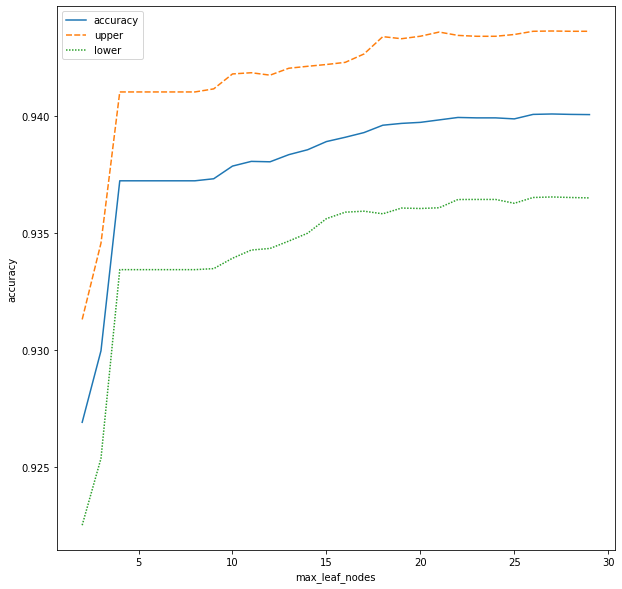

,accuracy,upper,lower
max_leaf_nodes,,,
27.0,0.94007,0.943609,0.936532


Test Accuracy : 0.941


In [64]:
tuning_param = 'max_leaf_nodes'
columns=[tuning_param, 'accuracy', 'upper', 'lower']

results = []
for m in np.arange(2, 30):
    cls = DecisionTreeClassifier(max_leaf_nodes=m)
    scores = cross_val_score(cls, scaler_1.transform(X_one_month_train), y_one_month_train, cv=k_folds)
    score = np.mean(scores)
    conf_int = np.std(scores) * 2
    results += [[m, score, score+conf_int, score-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('accuracy')
plt.show();

# Show chosen model
chosen_leaf = plot_df[plot_df['accuracy'] == plot_df['accuracy'].max()]
display(chosen_leaf)

# Use chosen model for test prediction
cls  = tree.DecisionTreeClassifier(max_leaf_nodes=int(chosen_leaf.index[0])).fit(scaler_1.transform(X_one_month_train), y_one_month_train)
y_hat = cls.predict(scaler_1.transform(X_one_month_test))
acc = accuracy_score(y_one_month_test, y_hat)

# Get proportion of correct classifications on test set
print('Test Accuracy : {}'.format(np.around(acc, 3)))

In [65]:
dot_data = tree.export_graphviz(cls, out_file=None,
                                feature_names=X_one_month_train.columns, 
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)
display(HTML(graph._repr_svg_()))

In [66]:
list_model["decision_tree_classifier"].append(dict({"cross_val_error" : plot_df['accuracy'].max()}))
list_model["decision_tree_classifier"].append(dict({"train_acc" : cls.score(scaler_1.transform(X_one_month_train), y_one_month_train)}))
list_model["decision_tree_classifier"].append(dict({"test_acc" : acc}))
list_model["decision_tree_classifier"].append(dict({"Variables" : X_one_month_train.columns[cls.feature_importances_ > 0].tolist()}))

In [67]:
list_model

defaultdict(list,
            {'lasso': [{'cross_val_error': 0.9224348077852099},
              {'train_acc': 0.9224435382685069},
              {'test_acc': 0.9208141642269623},
              {'Variables': ['mnt_ttc_echeance_std',
                'mnt_solde_charges_ccl_std',
                'mnt_ttc_facture_ccl_std',
                'mnt_sls_ccl_std',
                'mnt_aides_ccl_std',
                'mnt_total_encaisse_std',
                'nb_couple_av_enf_std',
                'nb_divorce_std',
                'nb_monoparental_std',
                'nb_veuf_std',
                'nb_celibataire_std',
                'nbr_enfant_std',
                'nb_couple_ss_enf_std',
                'nbr_occupant_menage_std',
                'mnt_ressource_mensuel_std',
                'nb_pacse_std',
                'mnt_plafond_plus_std',
                'nb_menage_autre_std',
                'nb_seul_std',
                'nb_concubin_std',
                'nb_marie_std',
             

### 2.1 Prune Tree

In [68]:
path = cls.cost_complexity_pruning_path(scaler_1.transform(X_one_month_train), y_one_month_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

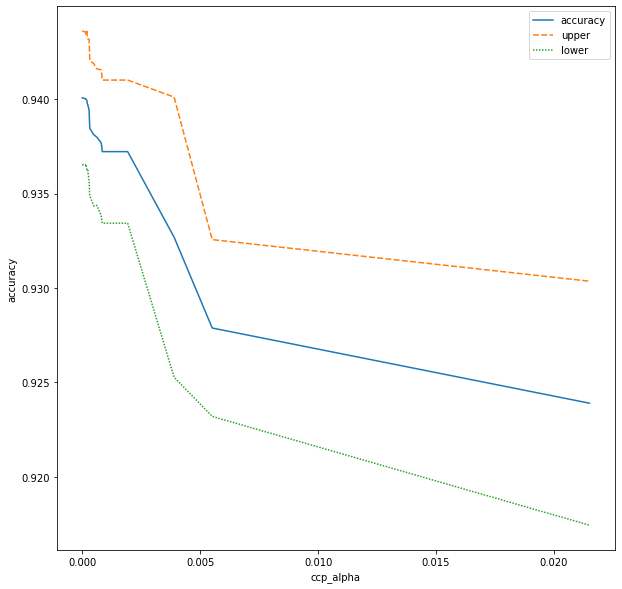

,accuracy,upper,lower
ccp_alpha,,,
0.0,0.94007,0.943609,0.936532


Test Accuracy : 0.941


In [69]:
tuning_param = 'ccp_alpha'
columns=[tuning_param, 'accuracy', 'upper', 'lower']
results = []

for m in ccp_alphas:
    cls_prune = DecisionTreeClassifier(max_leaf_nodes=int(chosen_leaf.index[0]), ccp_alpha=m)
    scores = cross_val_score(cls_prune, scaler_1.transform(X_one_month_train), y_one_month_train, cv=k_folds)
    score = np.mean(scores)
    conf_int = np.std(scores) * 2
    results += [[m, score, score+conf_int, score-conf_int]]


# Plot classification accuracy for each max_depth cv result
plot_df = pd.DataFrame(np.asarray(results), columns=columns).set_index(tuning_param)
plt.figure(figsize=(10,10))
sns.lineplot(data=plot_df)
plt.ylabel('accuracy')
plt.show();

# Show chosen model
chosen = plot_df[plot_df['accuracy'] == plot_df['accuracy'].max()]
display(chosen)

# Use chosen model for test prediction
cls_prune  = tree.DecisionTreeClassifier(ccp_alpha=chosen.index[0]).fit(scaler_1.transform(X_one_month_train), y_one_month_train)
y_hat = cls_prune.predict(scaler_1.transform(X_one_month_test))
acc_prune = accuracy_score(y_one_month_test, y_hat)

# Get proportion of correct classifications on test set
print('Test Accuracy : {}'.format(np.around(acc, 3)))

In [70]:
list_model["decision_tree_classifier_prune"].append(dict({"cross_val_error" : plot_df['accuracy'].max()}))
list_model["decision_tree_classifier_prune"].append(dict({"train_acc" : cls_prune.score(scaler_1.transform(X_one_month_train), y_one_month_train)}))
list_model["decision_tree_classifier_prune"].append(dict({"test_acc" : acc_prune}))
list_model["decision_tree_classifier_prune"].append(dict({"Variables" : X_one_month_train.columns[cls_prune.feature_importances_ > 0].tolist()}))

In [71]:
list_model

defaultdict(list,
            {'lasso': [{'cross_val_error': 0.9224348077852099},
              {'train_acc': 0.9224435382685069},
              {'test_acc': 0.9208141642269623},
              {'Variables': ['mnt_ttc_echeance_std',
                'mnt_solde_charges_ccl_std',
                'mnt_ttc_facture_ccl_std',
                'mnt_sls_ccl_std',
                'mnt_aides_ccl_std',
                'mnt_total_encaisse_std',
                'nb_couple_av_enf_std',
                'nb_divorce_std',
                'nb_monoparental_std',
                'nb_veuf_std',
                'nb_celibataire_std',
                'nbr_enfant_std',
                'nb_couple_ss_enf_std',
                'nbr_occupant_menage_std',
                'mnt_ressource_mensuel_std',
                'nb_pacse_std',
                'mnt_plafond_plus_std',
                'nb_menage_autre_std',
                'nb_seul_std',
                'nb_concubin_std',
                'nb_marie_std',
             

### 2.2 Bagging

In [72]:
max_features = X_one_month_train.shape[1]
tree_count   = 100

cls_bagging   = RandomForestClassifier(max_features=max_features, random_state=0, n_estimators=tree_count)

score = cross_val_score(cls_bagging, scaler_1.transform(X_one_month_train), y_one_month_train, cv=k_folds)

cls_bagging.fit(scaler_1.transform(X_one_month_train), y_one_month_train)
y_hat = cls_bagging.predict(scaler_1.transform(X_one_month_test))

acc_bagging = accuracy_score(y_one_month_test, y_hat)
print(f"accuracy bagging : {acc_bagging}")

accuracy bagging : 0.9615920814164227


In [73]:
score

array([0.96131393, 0.95800296, 0.96253376, 0.9589614 , 0.96018123,
       0.96052976, 0.95957132, 0.95809009, 0.96131056, 0.95773789])

In [74]:
list_model["decision_tree_classifier_bagging"].append(dict({"cross_val_error" : np.mean(score)}))
list_model["decision_tree_classifier_bagging"].append(dict({"train_acc" : cls_bagging.score(scaler_1.transform(X_one_month_train), y_one_month_train)}))
list_model["decision_tree_classifier_bagging"].append(dict({"test_acc" : acc_bagging}))
list_model["decision_tree_classifier_bagging"].append(dict({"Variables" : X_one_month_train.columns[cls_bagging.feature_importances_ > 0].tolist()}))

In [75]:
list_model

defaultdict(list,
            {'lasso': [{'cross_val_error': 0.9224348077852099},
              {'train_acc': 0.9224435382685069},
              {'test_acc': 0.9208141642269623},
              {'Variables': ['mnt_ttc_echeance_std',
                'mnt_solde_charges_ccl_std',
                'mnt_ttc_facture_ccl_std',
                'mnt_sls_ccl_std',
                'mnt_aides_ccl_std',
                'mnt_total_encaisse_std',
                'nb_couple_av_enf_std',
                'nb_divorce_std',
                'nb_monoparental_std',
                'nb_veuf_std',
                'nb_celibataire_std',
                'nbr_enfant_std',
                'nb_couple_ss_enf_std',
                'nbr_occupant_menage_std',
                'mnt_ressource_mensuel_std',
                'nb_pacse_std',
                'mnt_plafond_plus_std',
                'nb_menage_autre_std',
                'nb_seul_std',
                'nb_concubin_std',
                'nb_marie_std',
             

### 2.3 Random Forest

In [75]:
# dtree = DecisionTreeClassifier(criterion = "gini", splitter = 'best', max_leaf_nodes = 20, random_state = 42)
# list_model["decision_tree_classifier"].append(dict({"cross_val_error" : np.mean(cross_val_score(dtree, 
#                                                                              scaler_1.transform(X_one_month_train), 
#                                                                              y_one_month_train, 
#                                                                              cv = k_folds))}))
# dtree.fit(scaler_1.transform(X_one_month_train), y_one_month_train)
# list_model["decision_tree_classifier"].append(dict({"train_acc" : cls.score(scaler_1.transform(X_one_month_train), y_one_month_train)}))
# y_pred = dtree.predict(scaler_1.transform(X_one_month_test))
# list_model["decision_tree_classifier"].append(dict({"test_acc" : acc}))
# list_model["decision_tree_classifier"].append(dict({"Variables" : X_one_month_test.columns[lasso.coef_.ravel() != 0].tolist()}))

In [76]:
# dot_data = tree.export_graphviz(dtree, out_file=None,
#                                 feature_names=X_one_month_train.columns, 
#                                 filled=True, rounded=True)
# graph = graphviz.Source(dot_data)
# display(HTML(graph._repr_svg_()))